In [6]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import math
import random
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# import optuna

In [65]:
# CNN для обработки изображения
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorNet(nn.Module):
    def __init__(self, n_observations, n_actions, hidden_dim=16):
        super(ActorNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(32*92*92, 256)
        self.fc2 = nn.Linear(256, n_actions)


    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 32*92*92)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CriticNet(nn.Module):
    def __init__(self, n_observations, hidden_dim=16):
        super(CriticNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(32*92*92, 256)
        self.fc2 = nn.Linear(256, 1)


    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 32*92*92)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# Полносвязная сеть для небольшого набора состояний
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# class ActorNet(nn.Module):
#     def __init__(self, n_observations, n_actions, hidden_dim=16):
#         super(ActorNet, self).__init__()
#         self.layer1 = nn.Linear(n_observations, hidden_dim)
#         self.layer2 = nn.Linear(hidden_dim, n_actions)
#     def forward(self, x):
#         x = F.relu(self.layer1(x))
        
#         return self.layer2(x)

# class CriticNet(nn.Module):
#     def __init__(self, n_observations, hidden_dim=16):
#         super(CriticNet, self).__init__()
#         self.layer1 = nn.Linear(n_observations, hidden_dim)
#         self.layer2 = nn.Linear(hidden_dim, 1)
#     def forward(self, x):
#         x = F.relu(self.layer1(x))
        
#         return self.layer2(x)


In [59]:
# Агент для метода A2C
class A2CAgent:
    # Конструктор 
    def __init__(self, env, 
                 LR=0.001, DF=0.99, DEVICE='cpu', HDIM=16):
        # Среда
        self.env = env
        # Скорость обучения
        self.learning_rate = LR
        # Величина дисконтирования
        self.discount_factor = DF
        # Выбор размещения нейронных сетей
        self.device = DEVICE
        # Определяем нейронные сети целевую и политики
        # Первый параметр определяет количество наблюдений, второе число действий
        self.actor = ActorNet(len(self.env.reset()[0].reshape(-1)), self.env.action_space.n, HDIM).to(self.device)
        self.critic = CriticNet(len(self.env.reset()[0].reshape(-1)), HDIM).to(self.device)
        # Задаём оптимайзер для нейронной сети
        self.actor_optimizer = optim.AdamW(self.actor.parameters(), lr=self.learning_rate)
        self.critic_optimizer = optim.AdamW(self.actor.parameters(), lr=self.learning_rate)
        # Длины траекторий по эпизодам
        self.steps = []
        # Итоговое вознаграждение по эпизодам
        self.rewards = []

    def __totensor(self, x, tensortype=torch.float):
        return torch.tensor(x, dtype=tensortype).to(self.device)
    
    def __get_action(self, state):
        with torch.no_grad():
            state_batch = self.__totensor(np.expand_dims(state, axis=0))
            
            # state_batch = torch.tensor(state_batch, dtype=torch.float).to(self.device)

            actions = self.actor(state_batch).squeeze(dim=0)
            probabilies = F.softmax(actions, dim=-1)
            # проверить здесь размерности в зависимости от окружения
            actions = torch.multinomial(probabilies, num_samples=1)
            return actions.tolist()[0]

    # Обучение Агента
    def train(self, num_episodes=50, logfreq=20):
        # Обнуляем прошлый опыт
        self.rewards, self.steps = [], []
        for episode in tqdm(range(num_episodes)):
            
            steps = 0
            states, actions, rewards = [], [], []
            done = False

            state, _ = self.env.reset()
            # state = state.reshape(-1)
            
            while not done:
                states.append(state.tolist())
                
                action = self.__get_action(state)
                # Делаем шаг
                state, reward, terminated, truncated, _ = self.env.step(action)
                # state = state.reshape(-1)
                # Объединяем done по двум конечным состояниям
                done = terminated or truncated
                actions.append(action)
                rewards.append(reward)
                steps += 1
                
            self.steps.append(steps)

            cum_rewards = np.zeros_like(rewards)
            discounted_reward = 0
            for i in reversed(range(len(rewards))):
                discounted_reward = rewards[i] + discounted_reward * self.discount_factor
                cum_rewards[i] = discounted_reward


            self.critic_optimizer.zero_grad()
            states = self.__totensor(states)
            cum_rewards = self.__totensor(cum_rewards)

            values = self.critic(states).squeeze(dim=1)
            values_loss = F.mse_loss(values, cum_rewards)
            # values_loss = F.mse_loss(values, cum_rewards, reduction="None")
            values_loss.sum().backward()
            self.critic_optimizer.step()

            with torch.no_grad():
                values = self.critic(states)

            self.actor_optimizer.zero_grad()
            actions = self.__totensor(actions, torch.int64)
            advantages = cum_rewards - values

            logits = self.actor(states)
            log_probs = -F.cross_entropy(logits, actions)
            # log_probs = -F.cross_entropy(logits, actions, reduction="None")
            pi_loss = - log_probs * advantages

            pi_loss.sum().backward()
            self.actor_optimizer.step()
            
            self.rewards.append(sum(rewards))

            if (episode + 1)%logfreq == 0:
                print(f"Run episode {episode+1} with average reward {np.mean(self.rewards[-logfreq:])}", end="\r")

    def plot_rewards(self, window_size=10):
        # Сгладим графики
        smoothed_rewards = pd.Series(self.rewards).rolling(window_size, min_periods=window_size).mean()
        smoothed_steps = pd.Series(self.steps).rolling(window_size, min_periods=window_size).mean()

        plt.figure(figsize=(8, 12))
        plt.subplot(2, 1, 1)
        plt.plot(self.rewards)
        plt.plot(smoothed_rewards)
        plt.xlabel('Эпизод')
        plt.ylabel('Суммарное вознаграждение')
        plt.title('Оценка вознаграждения')

        plt.subplot(2, 1, 2)
        plt.plot(self.steps)
        plt.plot(smoothed_steps)
        plt.xlabel('Эпизод')
        plt.ylabel('Длина траектории')
        plt.title('Оценка длины траектории')

        plt.tight_layout()
        plt.show()

In [67]:
# env_names = [env for env in gym.envs.registry]

# # Выводим список названий сред
# for env_name in env_names:
#     print(env_name)

  4%|▍         | 20/500 [03:06<1:10:12,  8.78s/it]

  8%|▊         | 40/500 [06:01<1:11:08,  9.28s/it]

 12%|█▏        | 60/500 [08:50<1:02:51,  8.57s/it]

 16%|█▌        | 80/500 [11:31<55:20,  7.90s/it]  

 20%|██        | 100/500 [14:30<59:57,  8.99s/it] 

 24%|██▍       | 120/500 [17:21<57:52,  9.14s/it]

 28%|██▊       | 140/500 [20:08<48:52,  8.15s/it]

 32%|███▏      | 160/500 [23:00<48:16,  8.52s/it]

 36%|███▌      | 180/500 [25:54<42:46,  8.02s/it]

 40%|████      | 200/500 [28:46<40:10,  8.03s/it]

 44%|████▍     | 220/500 [31:44<39:24,  8.44s/it]

 48%|████▊     | 240/500 [34:37<37:22,  8.62s/it]

 52%|█████▏    | 260/500 [37:24<32:36,  8.15s/it]

 56%|█████▌    | 280/500 [40:11<31:16,  8.53s/it]

 60%|██████    | 300/500 [42:57<28:30,  8.55s/it]

 64%|██████▍   | 320/500 [45:45<25:41,  8.57s/it]

 68%|██████▊   | 340/500 [48:27<22:31,  8.45s/it]

 72%|███████▏  | 360/500 [51:14<19:54,  8.53s/it]

 76%|███████▌  | 380/500 [54:04<17:40,  8.84s/it]

 80%|████████  | 400/500 [56:50<13:51,  8.32s/it]

 84%|████████▍ | 420/500 [59:35<11:34,  8.69s/it]

 88%|████████▊ | 440/500 [1:02:31<09:10,  9.17s/it]

 92%|█████████▏| 460/500 [1:05:38<06:13,  9.33s/it]

 96%|█████████▌| 480/500 [1:08:27<02:45,  8.27s/it]

100%|██████████| 500/500 [1:11:24<00:00,  8.57s/it]

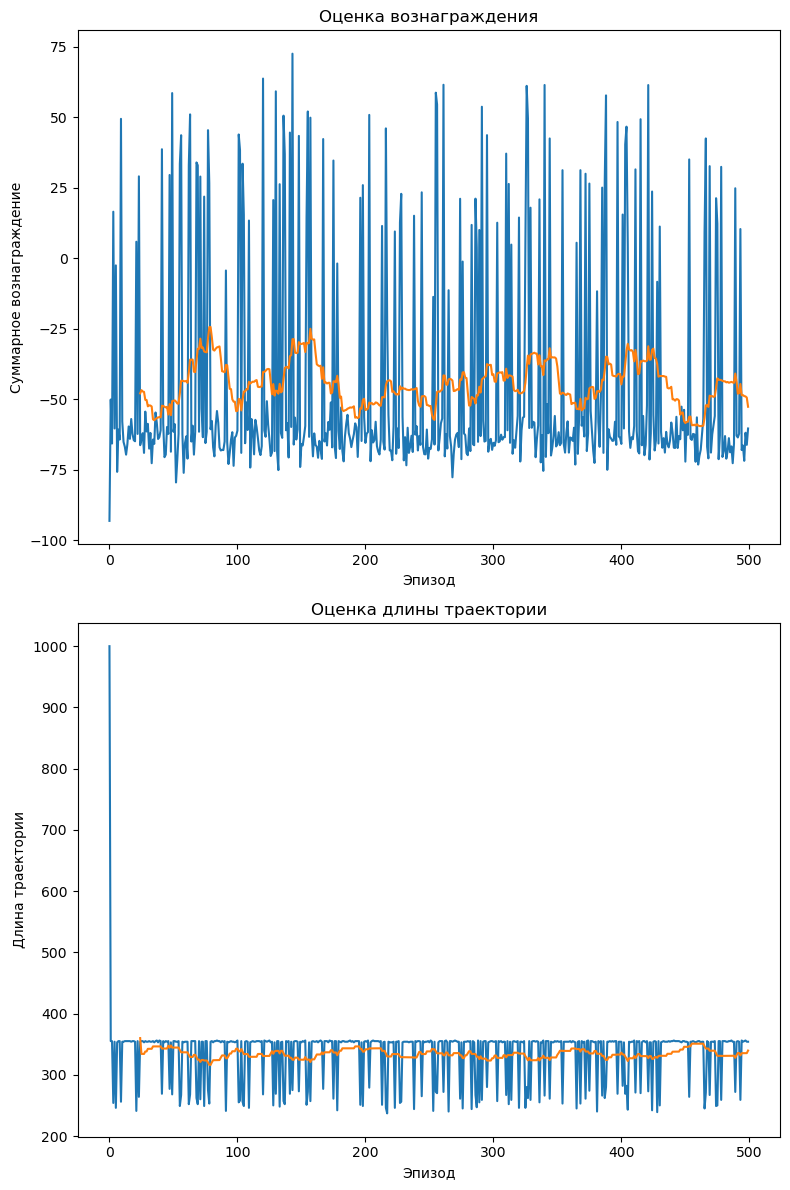

In [66]:
agent = A2CAgent(gym.make("CarRacing-v2", continuous=False), 
                  LR=1E-3, DEVICE="mps")
agent.train(num_episodes=500, logfreq=20)
agent.plot_rewards(25)